# Bike Rebalances EDA
Citibike does not provide data regarding bike rebalances, however, a bike that starts from a station where it did not end its previous trip it likely was either rebalanced or taken out of service. We will assume the former is the case for this preliminary exercise and consider ways to make this more robust in the future.

Future Work
- location based analysis was not faceted by time (year, month, DoW/weekend, holiday)
- interpretation of station/rebal rout significance not done due to lack of domain knowledge (basically we don't know why changes in time faceted rebalance work is significant but doable)

# TODO
- impute missing boros in stations file, fix boro (queens + queens county, ville marie...??)
- recreate rebalances tables
- rerun this code and update boro and neighborhood

## Load Data

In [ ]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", None)
%matplotlib inline

In [ ]:
print("loading...")
rebal = pd.read_parquet("../data/rebalance_parquet/all_rebalances_features.parquet")

# category conversions seemed like a good idea but really sucked when plotting
col_types = {
    # "bikeid": "category",
    "prevtrip_stoptime": "datetime64",
    "prevtrip_endstationid": "int16",
    "starttime": "datetime64",
    "startstationid": "int16",
    # "startstationname": "category",
    "startcapacity": "float16",
    # "startneighborhood": "category",
    # "startboro": "category",
    "startelevation_ft": "float16",
    # "prevtrip_endstationname": "category",
    "prevtrip_capacity": "float16",
    # "prevtrip_neighborhood": "category",
    # "prevtrip_boro": "category",
    "prevtrip_elevation_ft": "float16",
}

print("converting...")
rebal = rebal.astype(col_types)

rebal.head()

loading...
converting...


,bikeid,prevtrip_stoptime,prevtrip_endstationid,starttime,startstationid,startstationname,startcapacity,startneighborhood,startboro,startelevation_ft,prevtrip_endstationname,prevtrip_capacity,prevtrip_neighborhood,prevtrip_boro,prevtrip_elevation_ft
0,14529,2014-10-01 19:18:57,285,2014-10-01 23:27:47,345,W 13 St & 6 Ave,NaN,West Village,Manhattan,27.156250,Broadway & E 14 St,78.0,East Village,Manhattan,40.25000
1,14529,2014-10-01 23:36:23,438,2014-10-10 01:46:00,2002,Wythe Ave & Metropolitan Ave,57.0,NaN,Brooklyn,26.093750,St Marks Pl & 1 Ave,47.0,East Village,Manhattan,25.68750
2,14529,2014-10-10 09:22:03,243,2014-10-10 12:58:01,366,Clinton Ave & Myrtle Ave,33.0,NaN,Brooklyn,59.937500,Fulton St & Rockwell Pl,NaN,Fort Greene,NaN,34.06250
3,14529,2014-10-10 13:25:54,285,2014-10-10 15:20:17,116,W 17 St & 8 Ave,50.0,Chelsea,Manhattan,20.546875,Broadway & E 14 St,78.0,East Village,Manhattan,40.25000
4,14529,2014-10-10 18:48:50,477,2014-10-16 07:59:55,301,E 2 St & Avenue B,58.0,East Village,Manhattan,22.453125,W 41 St & 8 Ave,71.0,Theater District,Manhattan,42.46875


## Create Features

In [ ]:
# date/time features
rebal["rebal_dow"] = pd.DatetimeIndex(rebal["starttime"]).dayofweek
rebal["rebal_dom"] = pd.DatetimeIndex(rebal["starttime"]).day
rebal["rebal_week"] = pd.DatetimeIndex(rebal["starttime"]).week
rebal["rebal_month"] = pd.DatetimeIndex(rebal["starttime"]).month
rebal["rebal_year"] = pd.DatetimeIndex(rebal["starttime"]).year
rebal["rebal_time_hr"] = (rebal.starttime - rebal.prevtrip_stoptime) / np.timedelta64(
    1, "h"
)

# elevation features
rebal["rebal_elev_change"] = rebal.startelevation_ft - rebal.prevtrip_elevation_ft
bins = [0, 25, 50, 75, 100, 125, 150, 175, 200, 225, 250]
rebal["startelevation_bin"] = pd.cut(rebal.startelevation_ft, bins=bins)
rebal["prevtrip_elevation_bin"] = pd.cut(rebal.prevtrip_elevation_ft, bins=bins)

rebal.head()

/tmp/ipykernel_330/1387269630.py:4: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  rebal["rebal_week"] = pd.DatetimeIndex(rebal["starttime"]).week


,bikeid,prevtrip_stoptime,prevtrip_endstationid,starttime,startstationid,startstationname,startcapacity,startneighborhood,startboro,startelevation_ft,prevtrip_endstationname,prevtrip_capacity,prevtrip_neighborhood,prevtrip_boro,prevtrip_elevation_ft,rebal_dow,rebal_dom,rebal_week,rebal_month,rebal_year,rebal_elev_change,startelevation_bin,prevtrip_elevation_bin,rebal_time,rebal_time_hr
0,14529,2014-10-01 19:18:57,285,2014-10-01 23:27:47,345,W 13 St & 6 Ave,NaN,West Village,Manhattan,27.156250,Broadway & E 14 St,78.0,East Village,Manhattan,40.25000,2,1,40,10,2014,-13.093750,"(25, 50]","(25, 50]",4.147222,4.147222
1,14529,2014-10-01 23:36:23,438,2014-10-10 01:46:00,2002,Wythe Ave & Metropolitan Ave,57.0,NaN,Brooklyn,26.093750,St Marks Pl & 1 Ave,47.0,East Village,Manhattan,25.68750,4,10,41,10,2014,0.406250,"(25, 50]","(25, 50]",194.160278,194.160278
2,14529,2014-10-10 09:22:03,243,2014-10-10 12:58:01,366,Clinton Ave & Myrtle Ave,33.0,NaN,Brooklyn,59.937500,Fulton St & Rockwell Pl,NaN,Fort Greene,NaN,34.06250,4,10,41,10,2014,25.875000,"(50, 75]","(25, 50]",3.599444,3.599444
3,14529,2014-10-10 13:25:54,285,2014-10-10 15:20:17,116,W 17 St & 8 Ave,50.0,Chelsea,Manhattan,20.546875,Broadway & E 14 St,78.0,East Village,Manhattan,40.25000,4,10,41,10,2014,-19.703125,"(0, 25]","(25, 50]",1.906389,1.906389
4,14529,2014-10-10 18:48:50,477,2014-10-16 07:59:55,301,E 2 St & Avenue B,58.0,East Village,Manhattan,22.453125,W 41 St & 8 Ave,71.0,Theater District,Manhattan,42.46875,3,16,42,10,2014,-20.015625,"(0, 25]","(25, 50]",133.184722,133.184722


In [ ]:
rebal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7373117 entries, 0 to 7373116
Data columns (total 25 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   bikeid                   int64         
 1   prevtrip_stoptime        datetime64[ns]
 2   prevtrip_endstationid    int16         
 3   starttime                datetime64[ns]
 4   startstationid           int16         
 5   startstationname         object        
 6   startcapacity            float16       
 7   startneighborhood        category      
 8   startboro                category      
 9   startelevation_ft        float16       
 10  prevtrip_endstationname  object        
 11  prevtrip_capacity        float16       
 12  prevtrip_neighborhood    category      
 13  prevtrip_boro            category      
 14  prevtrip_elevation_ft    float16       
 15  rebal_dow                int64         
 16  rebal_dom                int64         
 17  rebal_week               in

## Rebalance Counts

### Unique Bikes Rebalanced

In [ ]:
# 32391 unique bikes rebalanced in total
rebal.bikeid.nunique()

32146

<AxesSubplot:title={'center':'Unique Bikes Rebalanced Per Year'}, xlabel='rebal_year'>

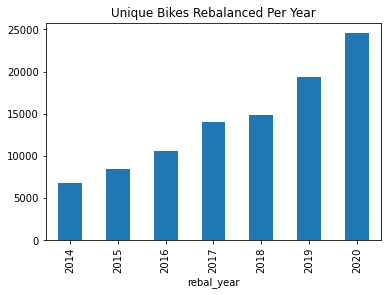

In [ ]:
# unique bikes rebalanced per year
rebal.groupby("rebal_year")["bikeid"].nunique().plot.bar(
    title="Unique Bikes Rebalanced Per Year"
)

### Total Bikes Rebalanced
- number of rebalances dropped sharply in 2018
  - number of unique bikes rebalanced close to 2017, but climbed sharply in 2019 and again in 2020
  - evidence of rebal rewards program?
- there is obvious seasonality in bike rebalances (months,days)
  -  likely follows trend in rides demand - to verify

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


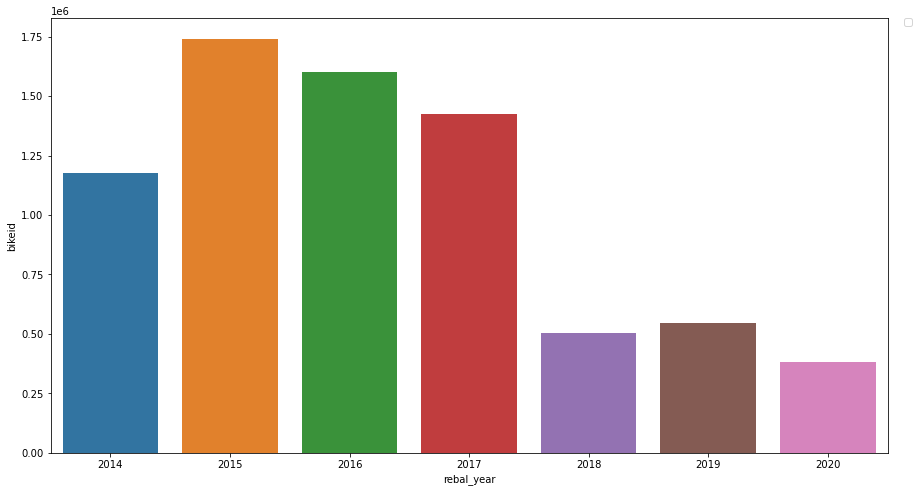

In [ ]:
# rebalances per year
g = rebal.groupby(["rebal_year"])[["bikeid"]].count().reset_index()
plt.figure(figsize=(15, 8))
x = sns.barplot(x=g.rebal_year, y=g.bikeid)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

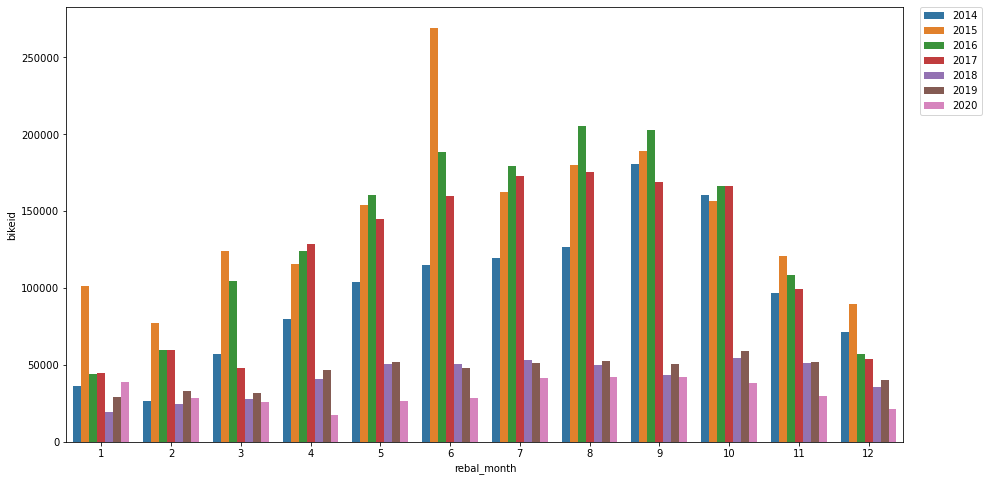

In [ ]:
# rebalances per month/year
g = rebal.groupby(["rebal_year", "rebal_month"])[["bikeid"]].count().reset_index()
plt.figure(figsize=(15, 8))
x = sns.barplot(x=g.rebal_month, y=g.bikeid, hue=g.rebal_year)
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

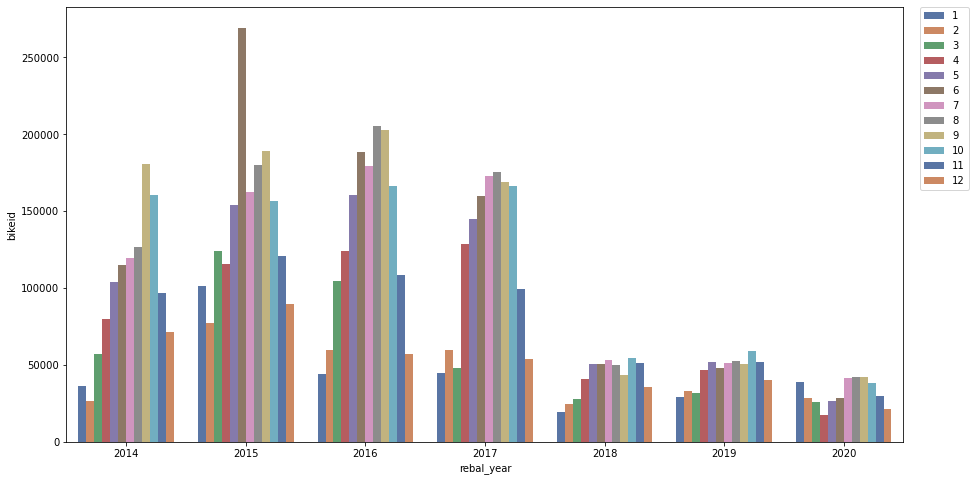

In [ ]:
# rebalances per month/year
g = rebal.groupby(["rebal_year", "rebal_month"])[["bikeid"]].count().reset_index()
plt.figure(figsize=(15, 8))
x = sns.barplot(x=g.rebal_year, y=g.bikeid, hue=g.rebal_month, palette="deep")
plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)

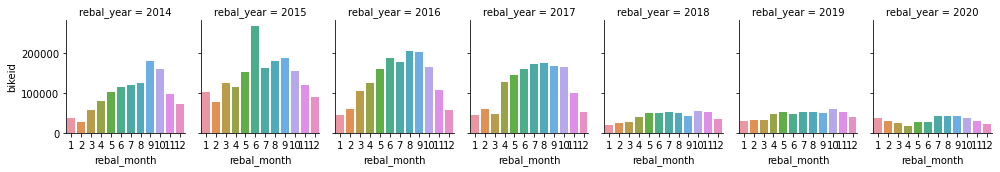

In [ ]:
# rebalances by month faceted by year
g = rebal.groupby(["rebal_year", "rebal_month"])[["bikeid"]].count().reset_index()
sns.catplot(
    x="rebal_month",
    y="bikeid",
    col="rebal_year",
    data=g,
    kind="bar",
    height=2.5,
    aspect=0.8,
)

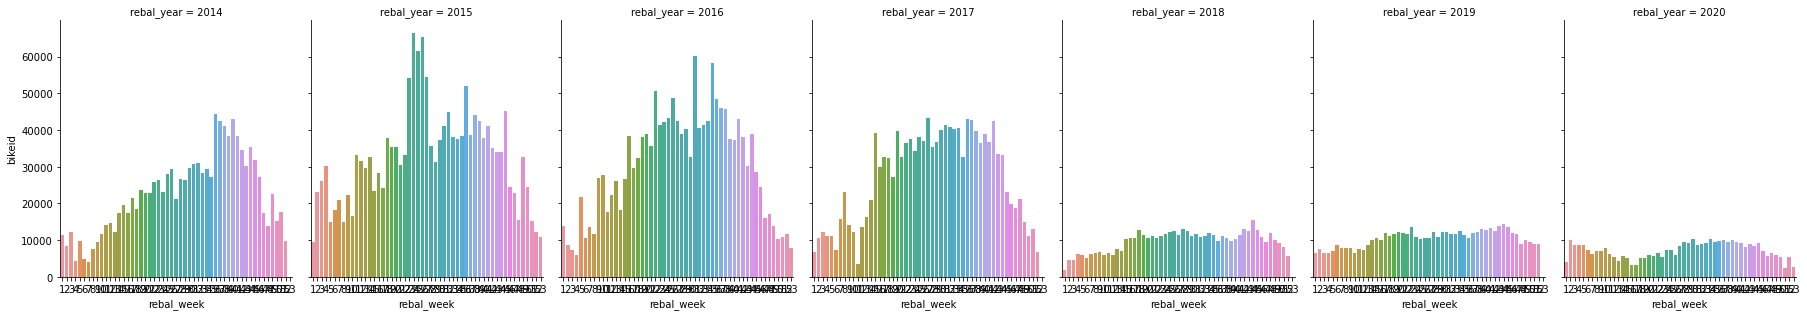

In [ ]:
# rebalances by week faceted by year
g = rebal.groupby(["rebal_year", "rebal_week"])[["bikeid"]].count().reset_index()
sns.catplot(
    x="rebal_week",
    y="bikeid",
    col="rebal_year",
    data=g,
    kind="bar",
    height=4.5,
    aspect=0.8,
)

<AxesSubplot:xlabel='rebal_dow', ylabel='bikeid'>

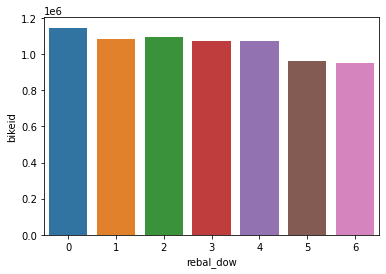

In [ ]:
# rebalances by DoW overall
g = rebal.groupby(["rebal_dow"])[["bikeid"]].count().reset_index()
sns.barplot(x="rebal_dow", y="bikeid", data=g)

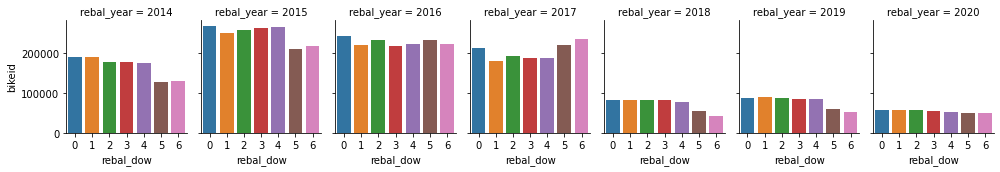

In [ ]:
# rebalances by DoW faceted by year
g = rebal.groupby(["rebal_year", "rebal_dow"])[["bikeid"]].count().reset_index()
sns.catplot(
    x="rebal_dow",
    y="bikeid",
    col="rebal_year",
    data=g,
    kind="bar",
    height=2.5,
    aspect=0.8,
)

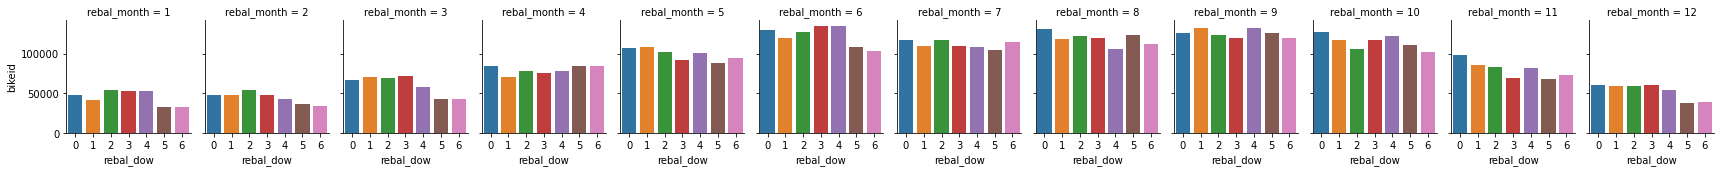

In [ ]:
# rebalances by DoW faceted by month
g = rebal.groupby(["rebal_month", "rebal_dow"])[["bikeid"]].count().reset_index()
sns.catplot(
    x="rebal_dow",
    y="bikeid",
    col="rebal_month",
    data=g,
    kind="bar",
    height=2.5,
    aspect=0.8,
)

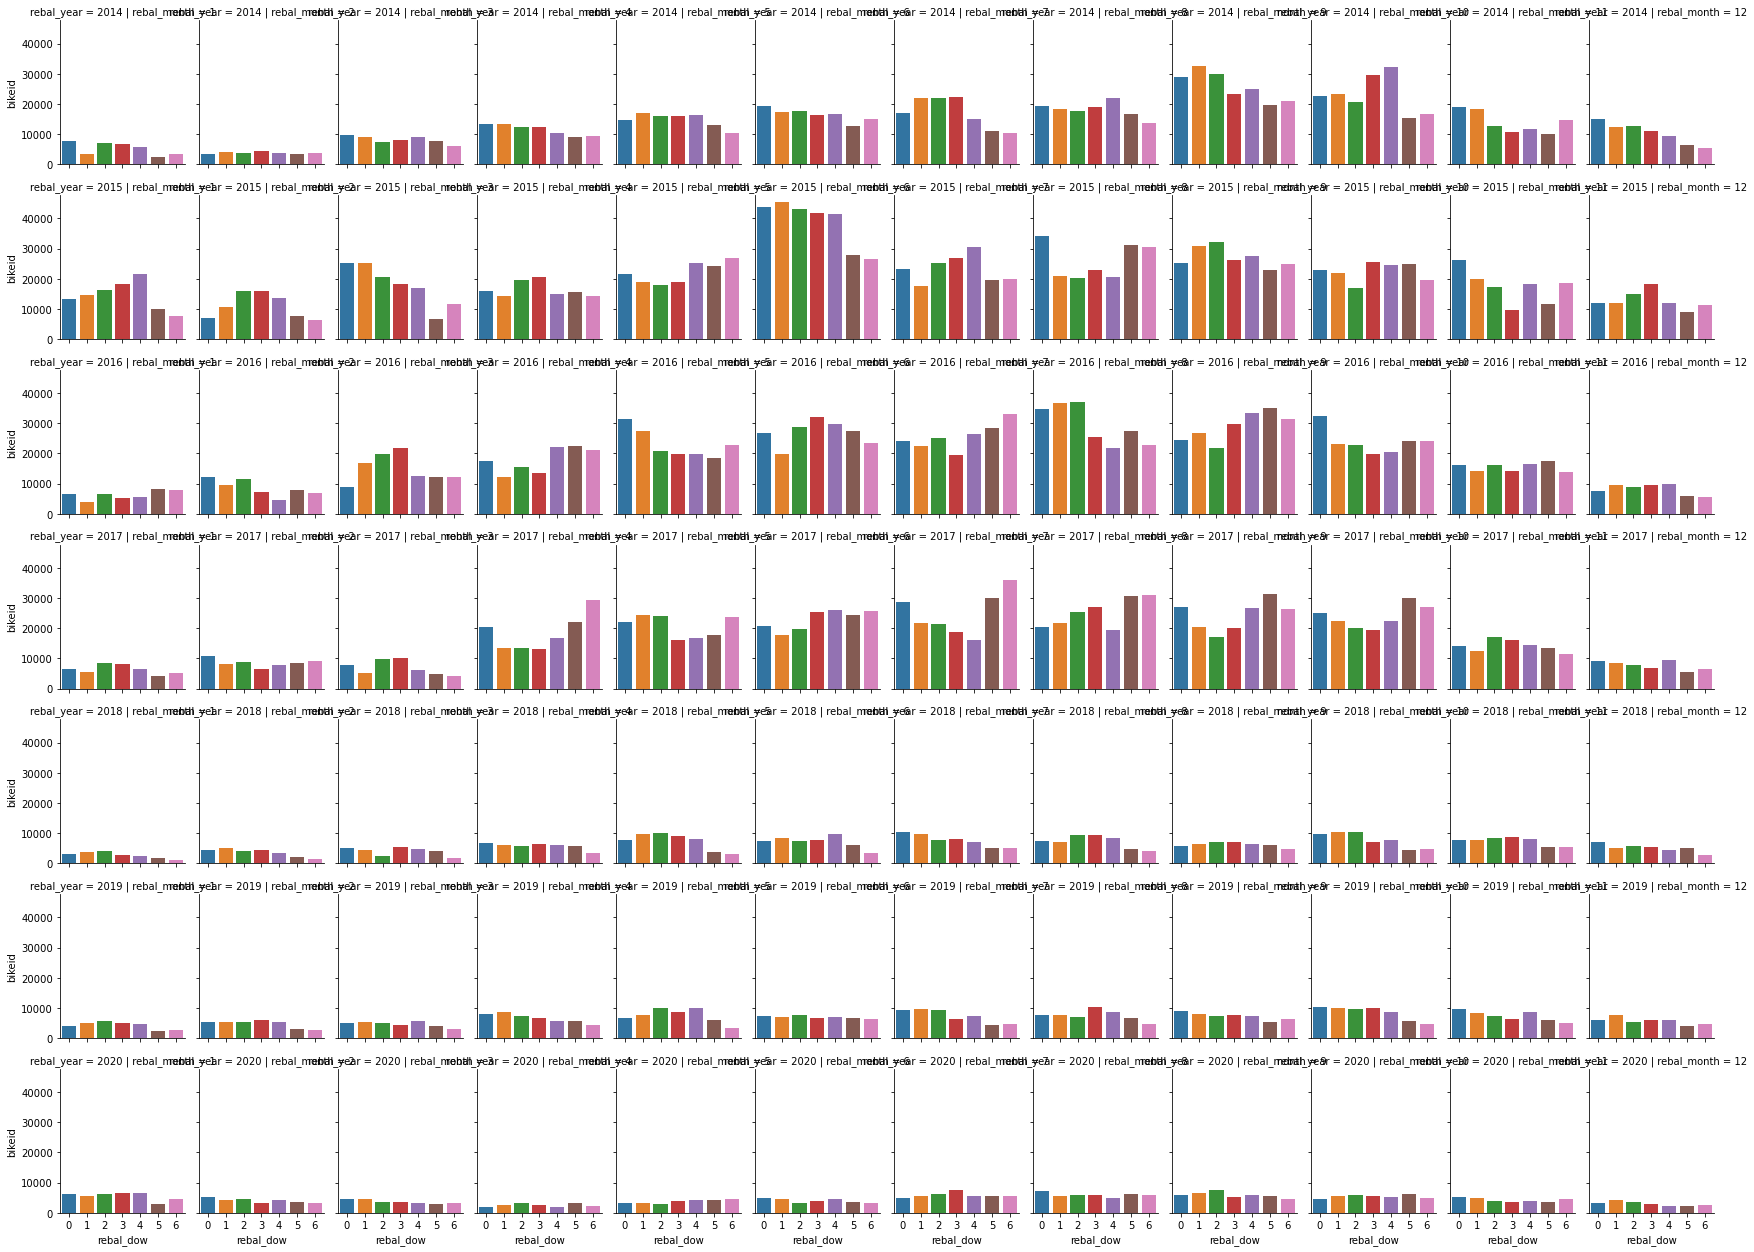

In [ ]:
# rebalances by DoW faceted by month and year
g = (
    rebal.groupby(["rebal_year", "rebal_month", "rebal_dow"])[["bikeid"]]
    .count()
    .reset_index()
)
sns.catplot(
    x="rebal_dow",
    y="bikeid",
    row="rebal_year",
    col="rebal_month",
    data=g,
    kind="bar",
    height=2.5,
    aspect=0.8,
)

## Elevation

### Change in elevation by each rebalance

<AxesSubplot:xlabel='rebal_elev_change', ylabel='Count'>

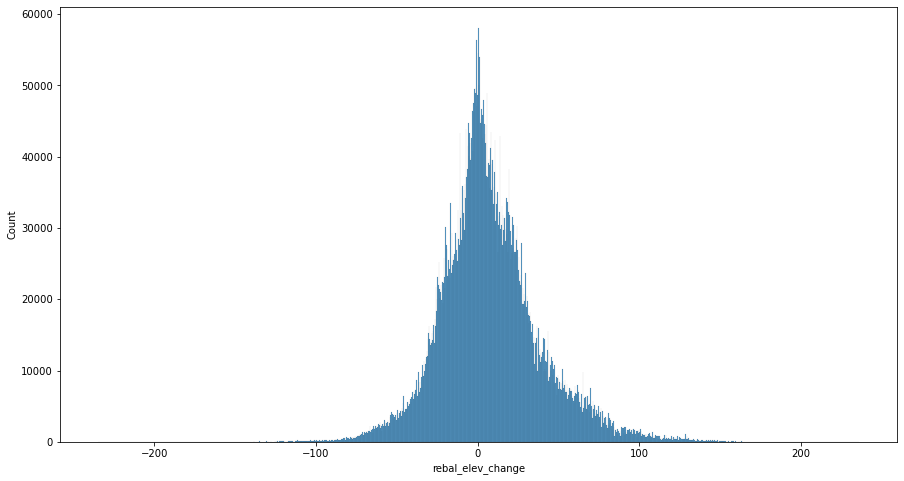

In [ ]:
# change in elevation for a given rebalance - overall
plt.figure(figsize=(15, 8))
sns.histplot(data=rebal, x="rebal_elev_change")

<AxesSubplot:xlabel='rebal_elev_change', ylabel='Count'>

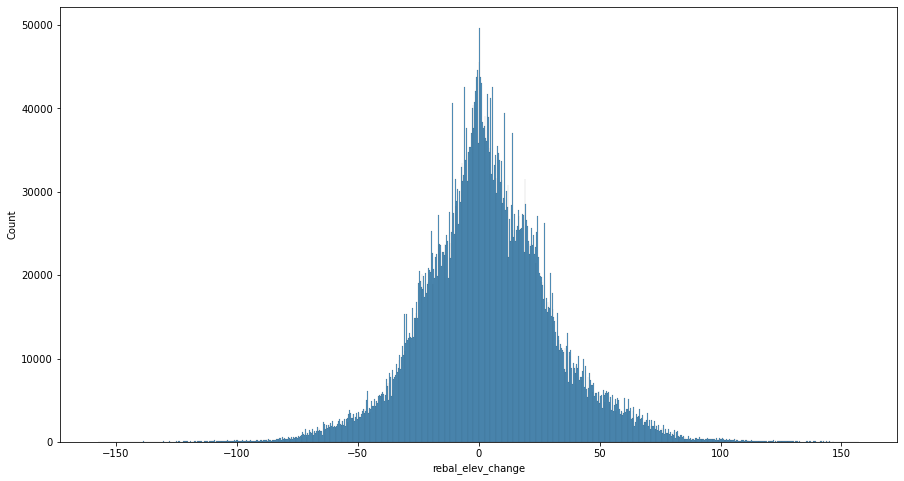

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(data=rebal.loc[rebal.rebal_year < 2018], x="rebal_elev_change")

<AxesSubplot:xlabel='rebal_elev_change', ylabel='Count'>

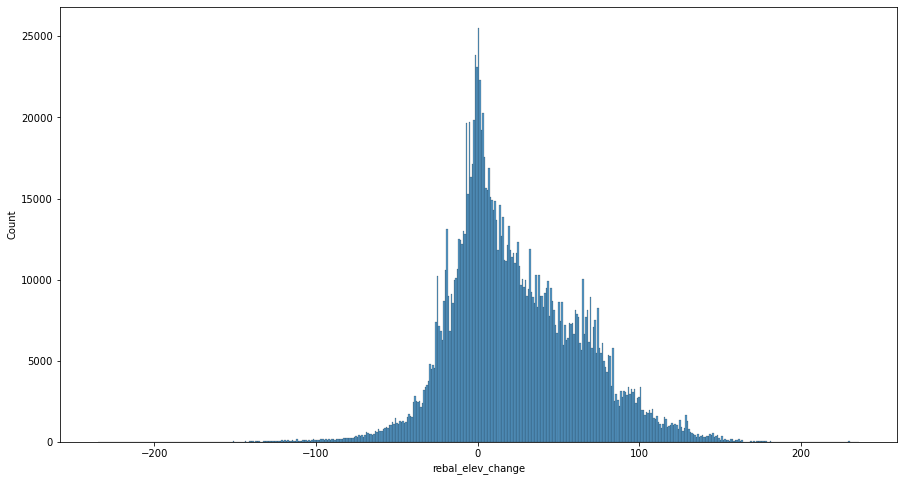

In [ ]:
plt.figure(figsize=(15, 8))
sns.histplot(data=rebal.loc[rebal.rebal_year >= 2018], x="rebal_elev_change")

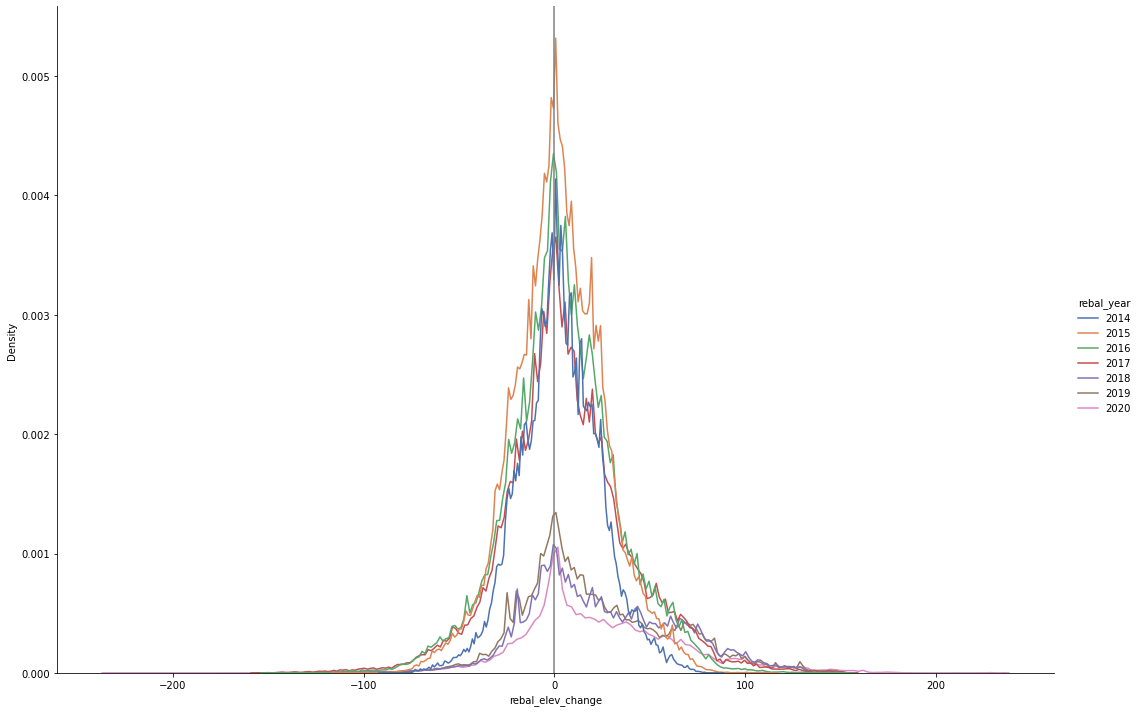

In [ ]:
sns.displot(
    data=rebal,
    x="rebal_elev_change",
    kind="kde",
    hue="rebal_year",
    bw_adjust=0.25,
    height=10,
    aspect=1.5,
    palette="deep",
)
plt.axvline(0, c="gray")

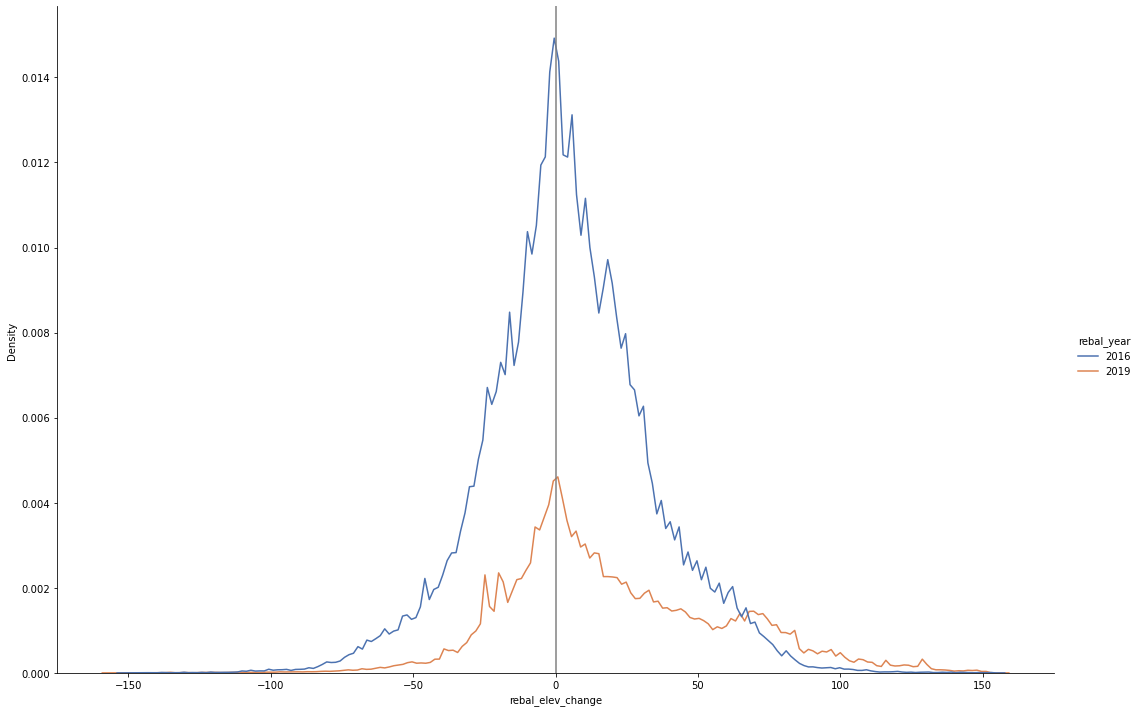

In [ ]:
sns.displot(
    data=rebal.loc[(rebal.rebal_year == 2016) | (rebal.rebal_year == 2019)],
    x="rebal_elev_change",
    kind="kde",
    hue="rebal_year",
    bw_adjust=0.25,
    height=10,
    aspect=1.5,
    palette="deep",
)
plt.axvline(0, c="gray")

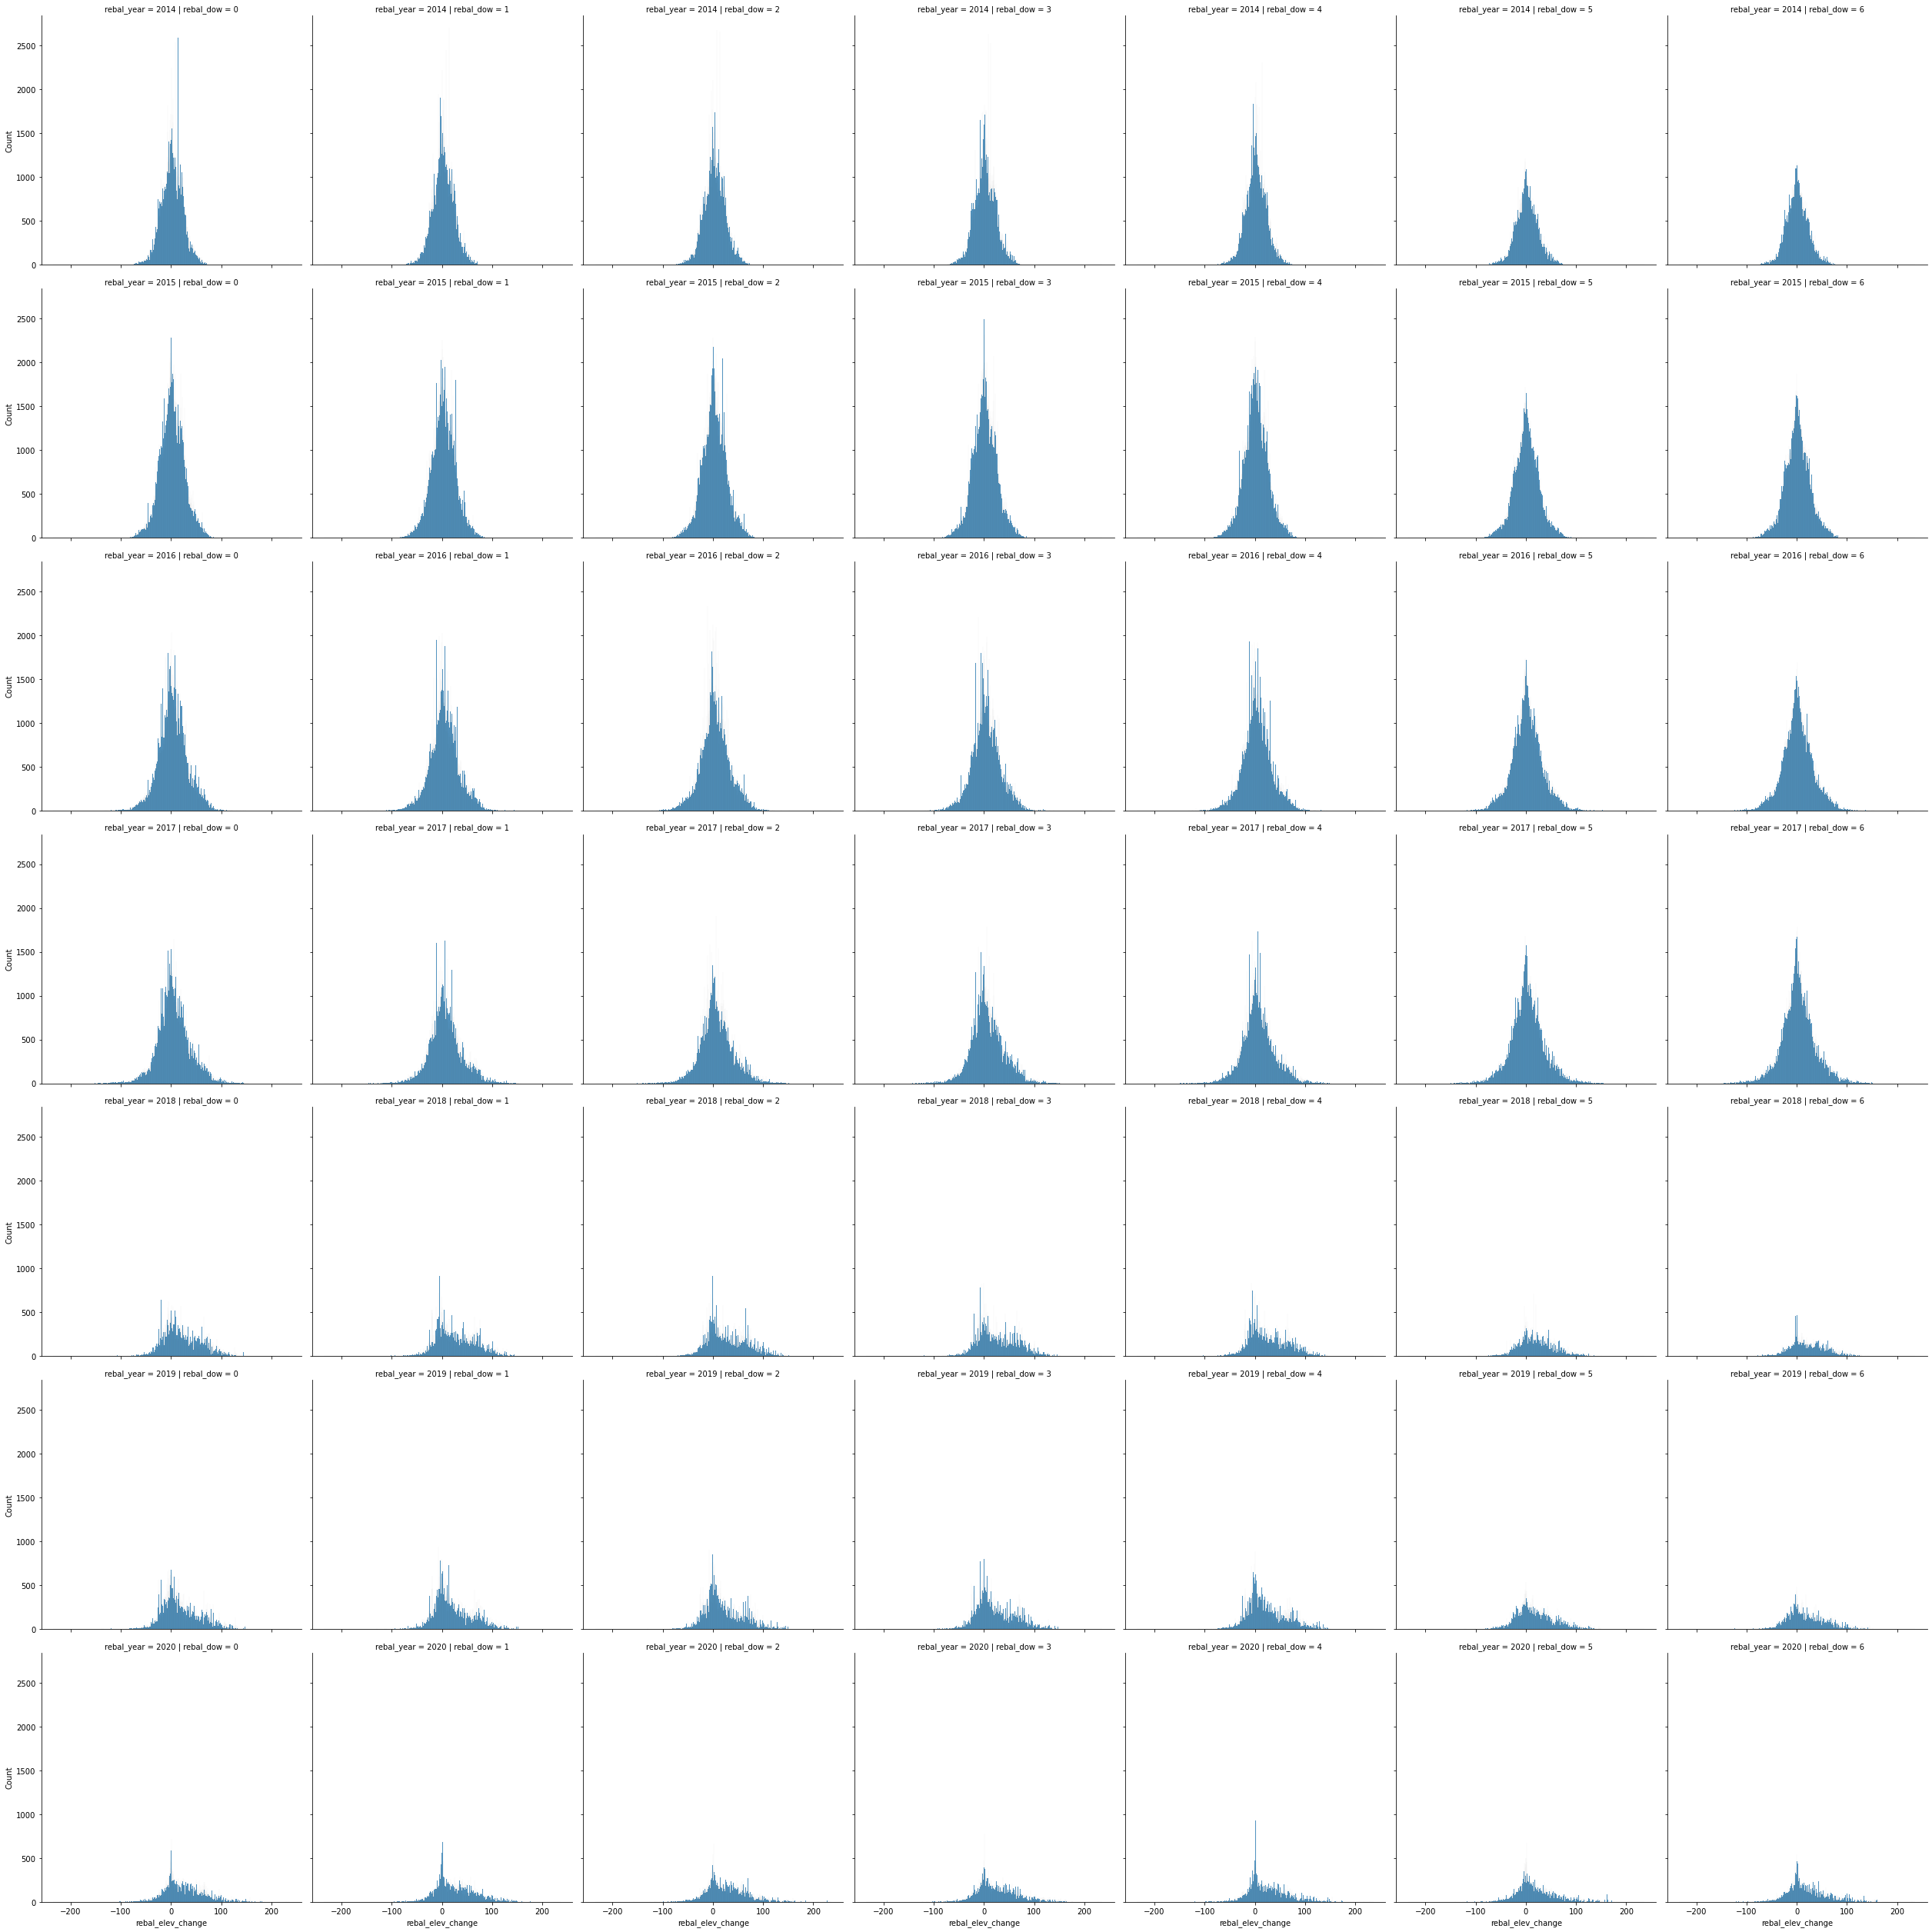

In [ ]:
# change in elevation for a given rebalance - faceted by year/month
sns.displot(
    data=rebal, x="rebal_elev_change", row="rebal_year", col="rebal_dow", kind="hist"
)

### Rebalance by aggregate elevation bins

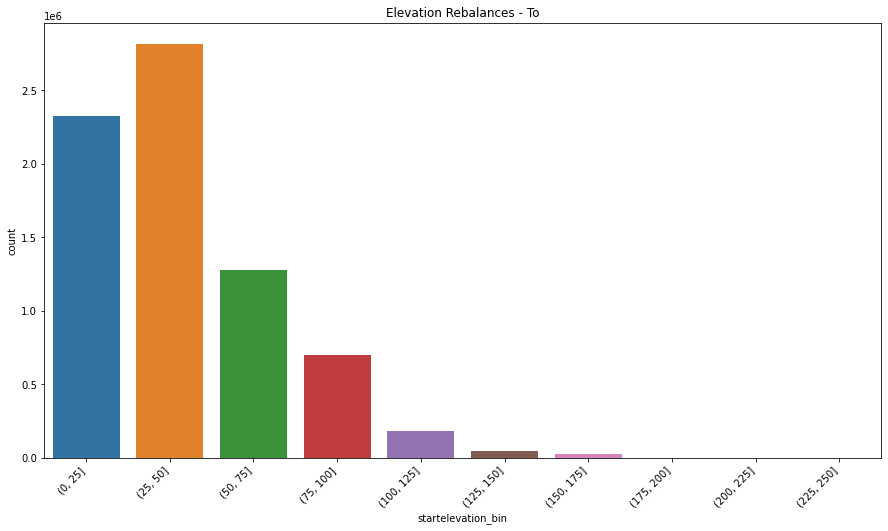

In [ ]:
# rebalances to elevation (binned)
plt.figure(figsize=(15, 8))
ax = sns.countplot(x=rebal.startelevation_bin)
ax.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
ax.set(title="Elevation Rebalances - To")
plt.show()

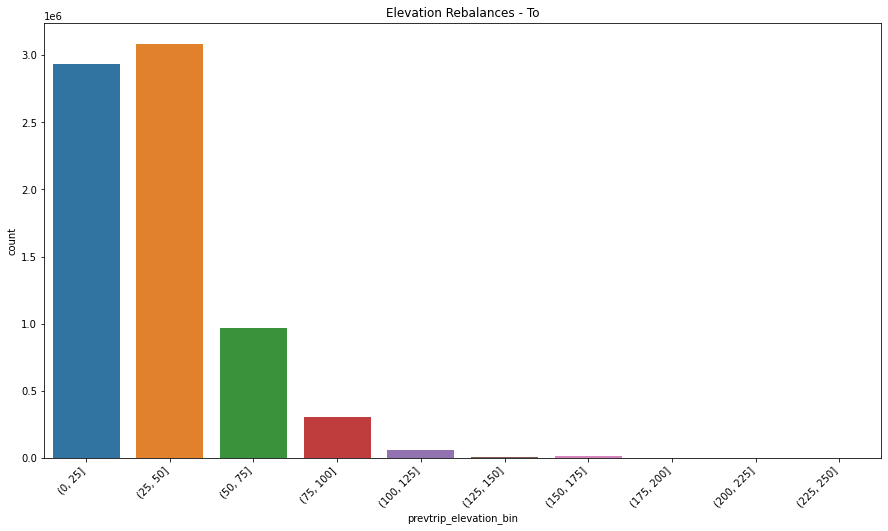

In [ ]:
# rebalances from elevation (binned)
plt.figure(figsize=(15, 8))
x = sns.countplot(x=rebal.prevtrip_elevation_bin)
x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
x.set(title="Elevation Rebalances - To")
plt.show()

/tmp/ipykernel_279/2219268431.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t["dir"] = "To"
/tmp/ipykernel_279/2219268431.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t.rename(columns={"startelevation_bin": "elevation"}, inplace=True)
/tmp/ipykernel_279/2219268431.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

[Text(0.5, 1.0, 'Elevation Rebalances - Overall')]

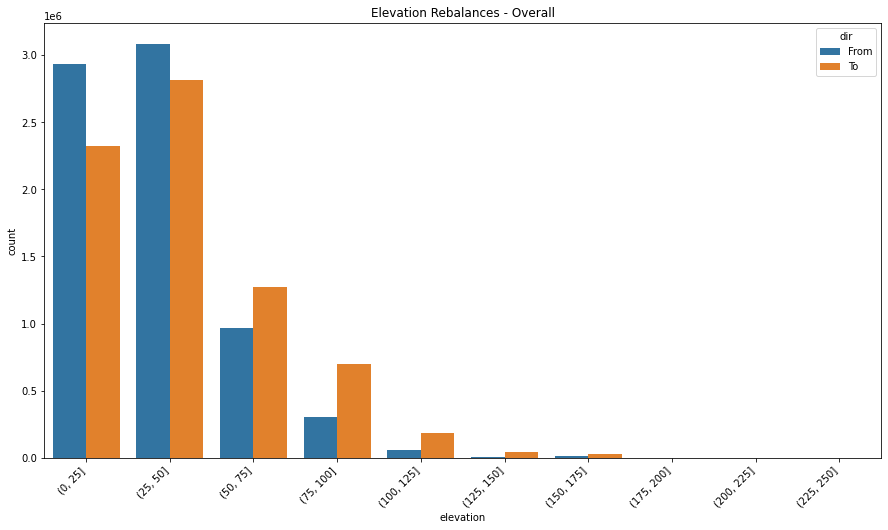

In [ ]:
# rebalances to & from (binned)
t = rebal[["startelevation_bin"]]
t["dir"] = "To"
t.rename(columns={"startelevation_bin": "elevation"}, inplace=True)
f = rebal[["prevtrip_elevation_bin"]]
f["dir"] = "From"
f.rename(columns={"prevtrip_elevation_bin": "elevation"}, inplace=True)
g = pd.concat([f, t], axis=0)
plt.figure(figsize=(15, 8))
x = sns.countplot(x=g.elevation, hue=g.dir)
x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
x.set(title="Elevation Rebalances - Overall")

## Capacity

In [ ]:
rebal.prevtrip_capacity.value_counts()

31.0    361122
39.0    326708
51.0    267917
66.0    237287
27.0    231470
         ...  
75.0      3895
0.0       3611
22.0      2060
17.0       866
16.0        46
Name: prevtrip_capacity, Length: 68, dtype: int64

In [ ]:
rebal.startcapacity.value_counts()

31.0    387541
39.0    365174
51.0    247240
66.0    226900
79.0    224561
         ...  
0.0       4290
26.0      4116
22.0      1729
17.0       744
16.0       121
Name: startcapacity, Length: 68, dtype: int64

<AxesSubplot:xlabel='startcapacity', ylabel='prevtrip_capacity'>

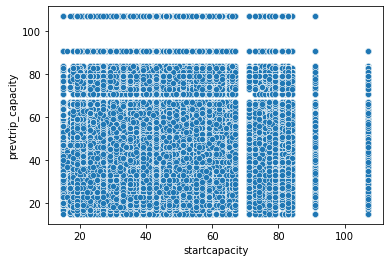

In [ ]:
sns.scatterplot(
    x=rebal.loc[rebal.startcapacity > 0].startcapacity,
    y=rebal.loc[rebal.prevtrip_capacity > 0].prevtrip_capacity,
)

In [ ]:
g = (
    rebal.groupby("startcapacity")["prevtrip_capacity"]
    .agg(["mean", "count"])
    .reset_index()
    .rename(columns={"mean": "mean_prevtrip_capacity", "count": "count_rebal"})
)
g = g.loc[g.startcapacity > 0]
g

,startcapacity,mean_prevtrip_capacity,count_rebal
1,15.0,46.593750,4444
2,16.0,27.984375,52
3,17.0,34.250000,629
4,18.0,49.312500,85107
5,19.0,44.250000,80066
...,...,...,...
63,82.0,45.812500,11741
64,83.0,48.062500,28029
65,84.0,48.187500,12635
66,91.0,48.812500,32626


<AxesSubplot:xlabel='startcapacity', ylabel='mean_prevtrip_capacity'>

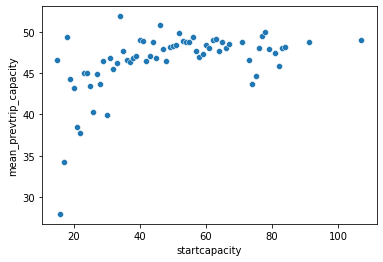

In [ ]:
# interesting...maybe?
sns.scatterplot(x=g.startcapacity, y=g.mean_prevtrip_capacity)

<AxesSubplot:xlabel='startcapacity', ylabel='count_rebal'>

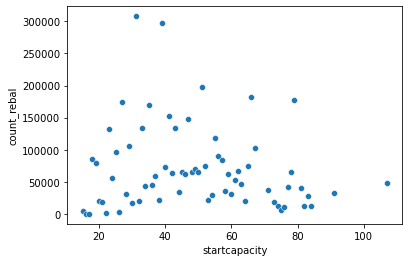

In [ ]:
# is this impactful?
sns.scatterplot(x=g.startcapacity, y=g.count_rebal)

## Station
No faceting performed, is possible if desired

### Indidual Station Analysis

In [ ]:
# why are these less than 0?
# should I include in top 20 plots?

In [ ]:
g.bikeid.min()

1

(0.0, 90133.3764536419)

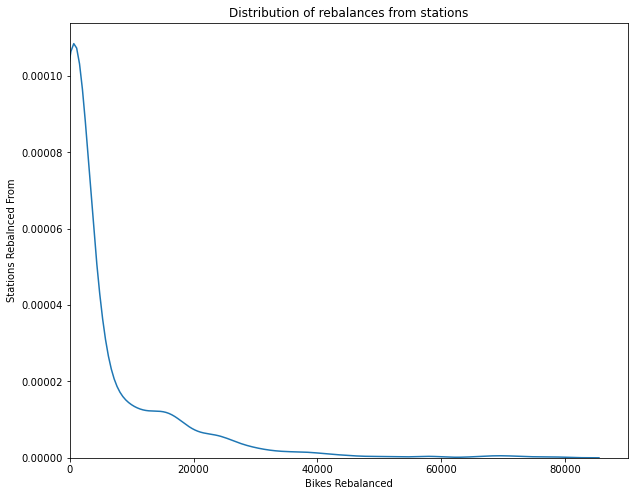

In [ ]:
# distribution of count of rebalances from
g = rebal.groupby("prevtrip_endstationname")[["bikeid"]].count()
plt.figure(figsize=(10, 8))
x = sns.kdeplot(x=g.bikeid)
x.set(
    title="Distribution of rebalances from stations",
    xlabel="Bikes Rebalanced",
    ylabel="Stations Rebalnced From",
)
plt.xlim(
    0,
)

(0.0, 109962.17015760118)

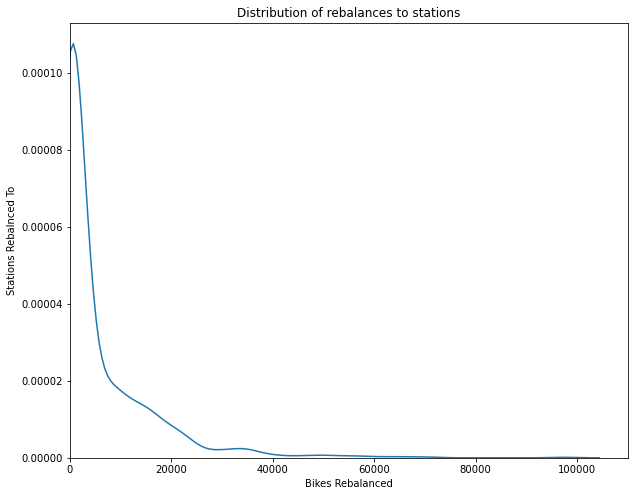

In [ ]:
# distribution of count of rebalances to
g = rebal.groupby("startstationname")[["bikeid"]].count()
plt.figure(figsize=(10, 8))
x = sns.kdeplot(x=g.bikeid)
x.set(
    title="Distribution of rebalances to stations",
    xlabel="Bikes Rebalanced",
    ylabel="Stations Rebalnced To",
)
plt.xlim(
    0,
)

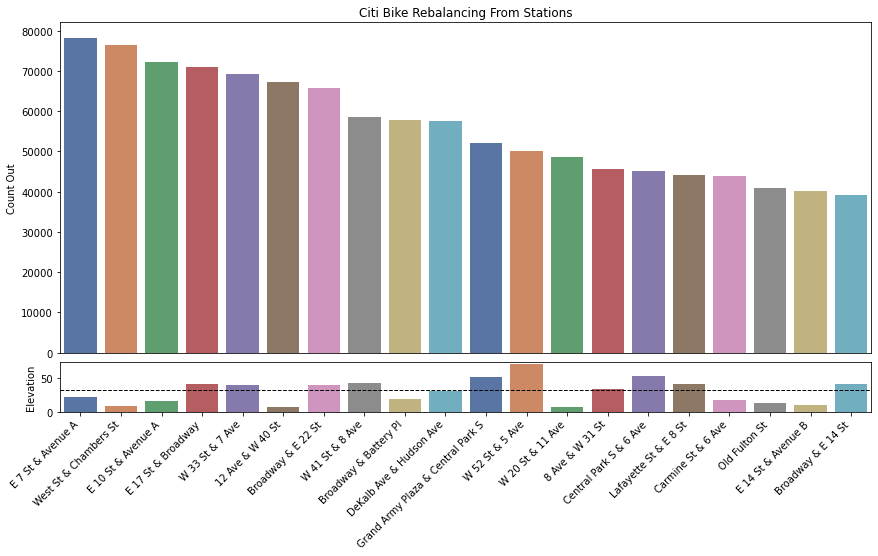

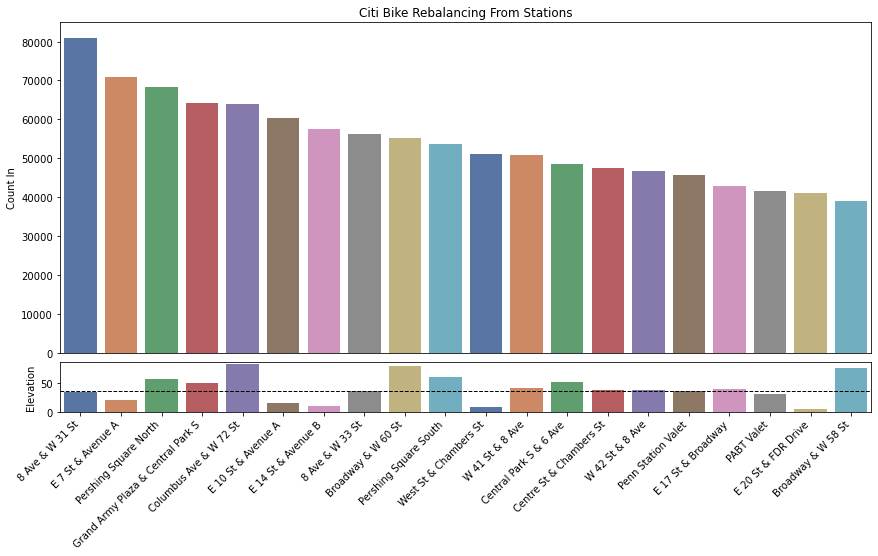

In [ ]:
# plot top20 rebalances
rebalout = (
    rebal[["prevtrip_endstationname", "prevtrip_elevation_ft"]]
    .value_counts()
    .reset_index()
    .rename(
        columns={
            "prevtrip_endstationname": "Station",
            "prevtrip_elevation_ft": "Elevation",
            0: "Count Out",
        }
    )[:20]
)

f, axs = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={"height_ratios": [1, 0.15]})
f.tight_layout()
f.subplots_adjust(hspace=0.05)
x = sns.barplot(x=rebalout.Station, y=rebalout["Count Out"], palette="deep", ax=axs[0])
x.set(title="Citi Bike Rebalancing From Stations", xlabel="", xticks=[])
y = sns.barplot(x=rebalout.Station, y=rebalout.Elevation, palette="deep", ax=axs[1])
y.set_xticklabels(y.get_xticklabels(), rotation=45, horizontalalignment="right")
y.set(xlabel="")
axs[1].axhline(rebal.prevtrip_elevation_ft.median(), c="black", lw=1, linestyle="--")
plt.show()


rebalin = (
    rebal[["startstationname", "startelevation_ft"]]
    .value_counts()
    .reset_index()
    .rename(
        columns={
            "startstationname": "Station",
            "startelevation_ft": "Elevation",
            0: "Count In",
        }
    )[:20]
)

f, axs = plt.subplots(2, 1, figsize=(12, 6), gridspec_kw={"height_ratios": [1, 0.15]})
f.tight_layout()
f.subplots_adjust(hspace=0.05)
x = sns.barplot(x=rebalin.Station, y=rebalin["Count In"], palette="deep", ax=axs[0])
x.set(title="Citi Bike Rebalancing From Stations", xlabel="", xticks=[])
y = sns.barplot(x=rebalin.Station, y=rebalin.Elevation, palette="deep", ax=axs[1])
y.set_xticklabels(y.get_xticklabels(), rotation=45, horizontalalignment="right")
y.set(xlabel="")
axs[1].axhline(rebal.startelevation_ft.median(), c="black", lw=1, linestyle="--")
plt.show()

### Pairwise Station Analysis

In [ ]:
# group by pairs and count number per pair
rebpair = (
    rebal.groupby(["startstationname", "prevtrip_endstationname"])[["bikeid"]]
    .count()
    .reset_index()
    .sort_values(by="bikeid", ascending=False)
)
rebpair.rename(columns={"bikeid": "rebal_count"}, inplace=True)

# filter for only pairs that have been rebalanced more than ~10 times
rebpair = rebpair.loc[rebpair.rebal_count > 10]

# add elevation change column, round for easier plotting
rebpair = rebpair.merge(
    rebal[["startelevation_ft", "startstationname"]].drop_duplicates(
        subset="startstationname"
    ),
    how="left",
    on="startstationname",
).merge(
    rebal[["prevtrip_elevation_ft", "prevtrip_endstationname"]].drop_duplicates(
        subset="prevtrip_endstationname"
    ),
    how="left",
    on="prevtrip_endstationname",
)
rebpair["rebal_elev_change"] = rebpair.startelevation_ft - rebpair.prevtrip_elevation_ft
rebpair.drop(columns=["startelevation_ft", "prevtrip_elevation_ft"], inplace=True)
rebpair.rebal_elev_change = rebpair.rebal_elev_change.round()

# add capacity change column
rebpair = rebpair.merge(
    rebal[["startcapacity", "startstationname"]].drop_duplicates(
        subset="startstationname"
    ),
    how="left",
    on="startstationname",
).merge(
    rebal[["prevtrip_capacity", "prevtrip_endstationname"]].drop_duplicates(
        subset="prevtrip_endstationname"
    ),
    how="left",
    on="prevtrip_endstationname",
)
rebpair = rebpair.astype({"startcapacity": "float32", "prevtrip_capacity": "float32"})
rebpair["rebal_cap_change"] = rebpair.startcapacity - rebpair.prevtrip_capacity
rebpair.drop(columns=["startcapacity", "prevtrip_capacity"], inplace=True)
rebpair.rebal_elev_change = rebpair.rebal_elev_change.round()

# add id columns
rebpair = rebpair.merge(
    rebal[["startstationid", "startstationname"]].drop_duplicates(
        subset="startstationname"
    ),
    how="left",
    on="startstationname",
).merge(
    rebal[["prevtrip_endstationid", "prevtrip_endstationname"]].drop_duplicates(
        subset="prevtrip_endstationname"
    ),
    how="left",
    on="prevtrip_endstationname",
)
rebpair.rename(
    columns={
        "startstationid": "stationid_to",
        "prevtrip_endstationid": "stationid_from",
    },
    inplace=True,
)

# a very small number of rows contain elevations that are +/- inf, change to 0 and ignore
rebpair.loc[rebpair.rebal_elev_change < -300, "rebal_elev_change"] = 0
rebpair.loc[rebpair.rebal_elev_change > 300, "rebal_elev_change"] = 0

# create a single string for rebalance route
rebpair["rebal_route"] = (
    rebpair.prevtrip_endstationname.astype("str")
    + " to "
    + rebpair.startstationname.astype("str")
)

rebpair[:20]

,startstationname,prevtrip_endstationname,rebal_count,rebal_elev_change,rebal_cap_change,stationid_to,stationid_from,rebal_route
0,E 14 St & Avenue B,E 7 St & Avenue A,12605,-11.0,0.0,511,432,E 7 St & Avenue A to E 14 St & Avenue B
1,Broadway & W 41 St,W 41 St & 8 Ave,9847,14.0,-32.0,465,477,W 41 St & 8 Ave to Broadway & W 41 St
2,E 20 St & FDR Drive,E 7 St & Avenue A,6919,-17.0,NaN,487,432,E 7 St & Avenue A to E 20 St & FDR Drive
3,E 7 St & Avenue A,E 14 St & Avenue B,6670,11.0,0.0,432,511,E 14 St & Avenue B to E 7 St & Avenue A
4,E 7 St & Avenue A,Cooper Square & E 7 St,6237,-20.0,NaN,432,3263,Cooper Square & E 7 St to E 7 St & Avenue A
5,W 52 St & 5 Ave,W 41 St & 8 Ave,5715,27.0,NaN,520,477,W 41 St & 8 Ave to W 52 St & 5 Ave
6,Pershing Square North,E 47 St & Park Ave,5605,0.0,NaN,519,359,E 47 St & Park Ave to Pershing Square North
7,E 14 St & Avenue B,E 20 St & FDR Drive,4950,6.0,NaN,511,487,E 20 St & FDR Drive to E 14 St & Avenue B
8,Broadway & W 36 St,W 33 St & 7 Ave,4875,8.0,NaN,267,492,W 33 St & 7 Ave to Broadway & W 36 St
9,8 Ave & W 33 St,8 Ave & W 31 St,4860,2.0,48.0,490,521,8 Ave & W 31 St to 8 Ave & W 33 St


In [ ]:
rebpair.shape

(406299, 6)

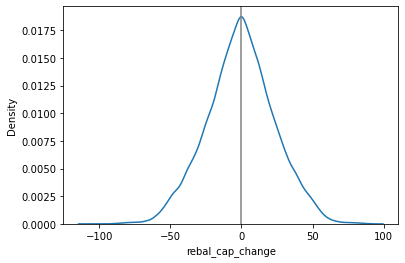

In [ ]:
# pairwise capacity change
sns.kdeplot(x=rebpair.rebal_cap_change)
plt.axvline(0, c="gray")

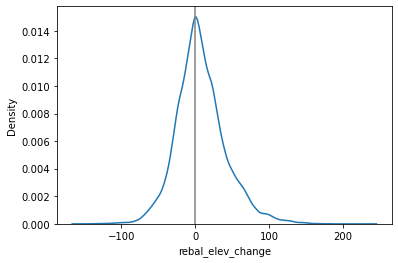

In [ ]:
# pairwise elevation change rebalances
sns.kdeplot(x=rebpair.rebal_elev_change)
plt.axvline(0, c="gray")

[Text(0.5, 1.0, 'Distribution of pairwise rebalances'),
 Text(0.5, 0, 'Bikes Rebalanced'),
 Text(0, 0.5, 'Station Pairs')]

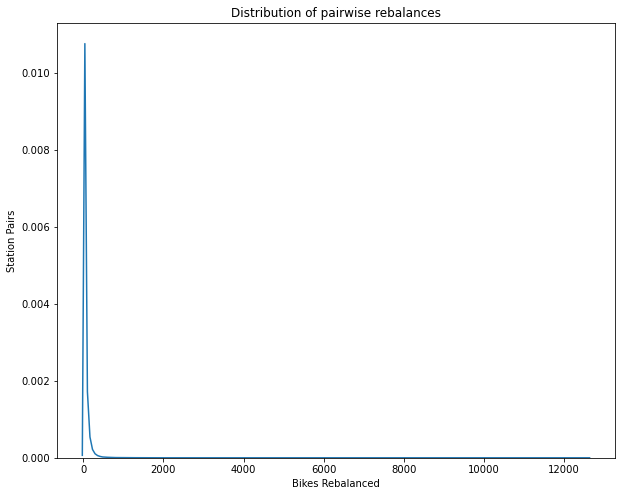

In [ ]:
# distribution of count of pairwise rebalances
plt.figure(figsize=(10, 8))
x = sns.kdeplot(x=rebpair.rebal_count)
x.set(
    title="Distribution of pairwise rebalances",
    xlabel="Bikes Rebalanced",
    ylabel="Station Pairs",
)

[Text(0.5, 1.0, 'Most Frequent Rebalance Routes'),
 Text(0.5, 0, ''),
 Text(0, 0.5, 'Number of Bikes Rebalanced')]

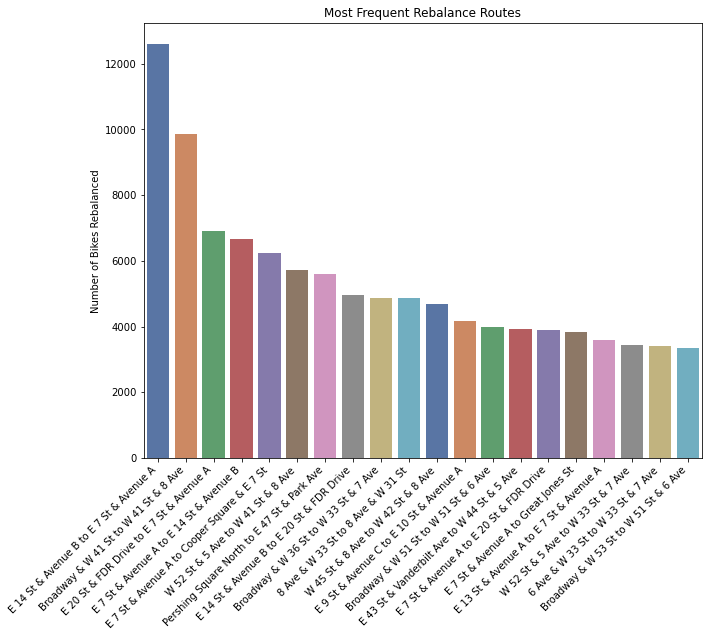

In [ ]:
# plot most frequent rebalance routes, ordered by count (top 20)
plt.figure(figsize=(10, 8))
x = sns.barplot(y=rebpair.rebal_count, x=rebpair.rebal_route[:20], palette="deep")
x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
x.set(
    title="Most Frequent Rebalance Routes",
    xlabel="",
    ylabel="Number of Bikes Rebalanced",
)

(0.0, 1.0, 0.0, 1.0)

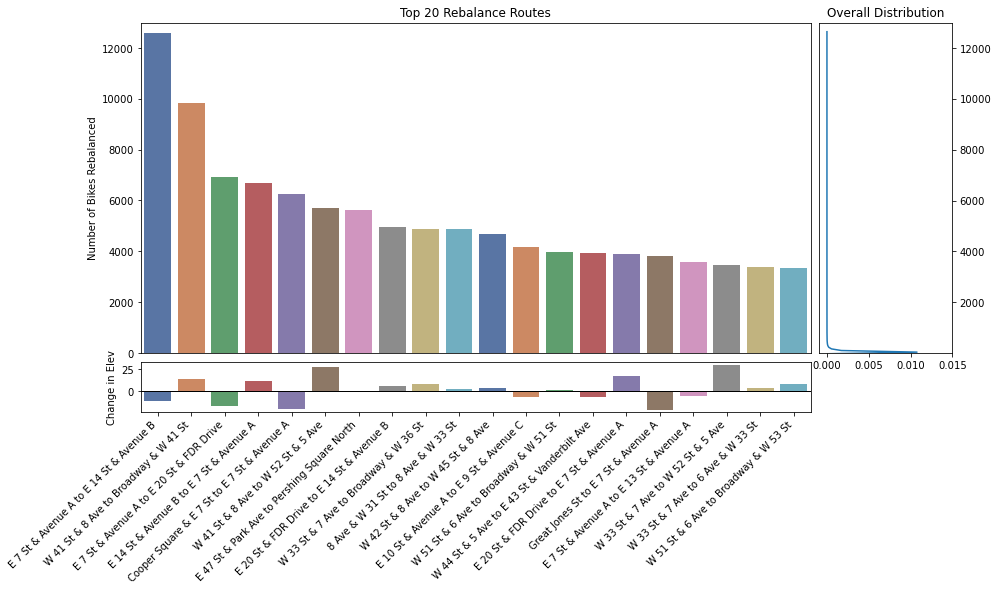

In [ ]:
# combine above with elevation data and rebal route distribution
f, axs = plt.subplots(
    2,
    2,
    figsize=(12, 6),
    gridspec_kw={"height_ratios": [1, 0.15], "width_ratios": [1, 0.2]},
)
f.tight_layout()
f.subplots_adjust(wspace=0.02, hspace=0.05)

# plot rebal routes
y = sns.barplot(
    y=rebpair.rebal_count, x=rebpair.rebal_route[:20], ax=axs[0, 0], palette="deep"
)
y.set(xticklabels=[], xticks=[], ylim=(0, 13000))
y.set(
    title="Top 20 Rebalance Routes",
    xlabel="",
    ylabel="Number of Bikes Rebalanced",
)

# plot rebal elevaton changes
x = sns.barplot(
    y=rebpair.rebal_elev_change,
    x=rebpair.rebal_route[:20],
    ax=axs[1, 0],
    palette="deep",
)
x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
x.set(
    xlabel="",
    ylabel="Change in Elev",
)
axs[1, 0].axhline(0, c="black", lw=1)

# plot rebal distribution
z = sns.kdeplot(y=rebpair.rebal_count, ax=axs[0, 1], log_scale=[False, False])
z.set(
    ylim=(9, 13000),
    xlim=(-0.001, 0.015),
    title="Overall Distribution",
    xlabel="",
    ylabel="",
)
axs[0, 1].yaxis.tick_right()


# hide last axis
axs[-1, -1].axis("off")

(0.0, 1.0, 0.0, 1.0)

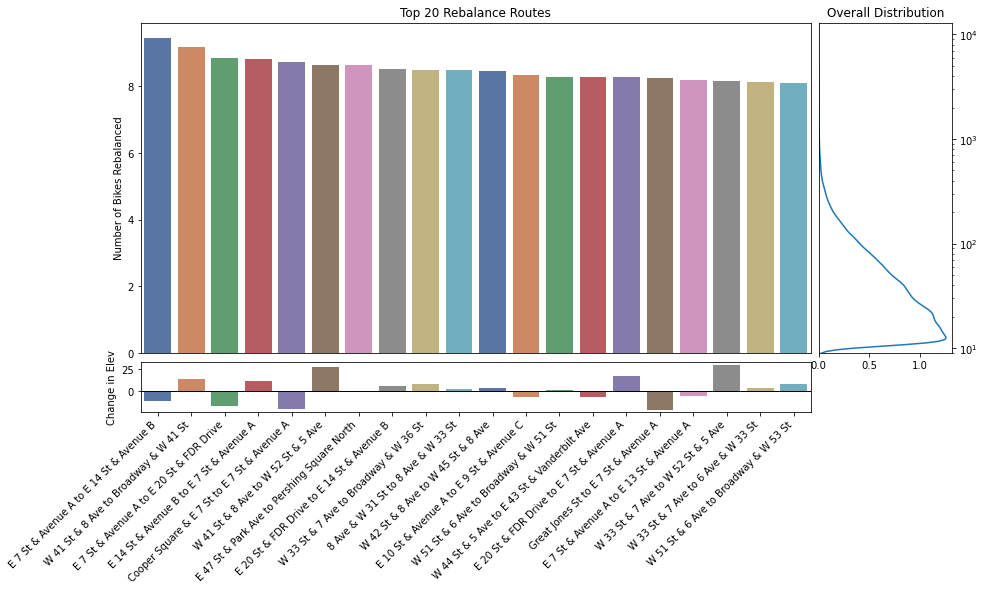

In [ ]:
# combine above with elevation data and rebal route distribution
f, axs = plt.subplots(
    2,
    2,
    figsize=(12, 6),
    gridspec_kw={"height_ratios": [1, 0.15], "width_ratios": [1, 0.2]},
)
f.tight_layout()
f.subplots_adjust(wspace=0.02, hspace=0.05)

# plot rebal routes
y = sns.barplot(
    y=np.log(rebpair.rebal_count),
    x=rebpair.rebal_route[:20],
    ax=axs[0, 0],
    palette="deep",
)
y.set(xticklabels=[], xticks=[])
y.set(
    title="Top 20 Rebalance Routes",
    xlabel="",
    ylabel="Number of Bikes Rebalanced",
)
###### fix y axis

# plot rebal elevaton changes
x = sns.barplot(
    y=rebpair.rebal_elev_change,
    x=rebpair.rebal_route[:20],
    ax=axs[1, 0],
    palette="deep",
)
x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
x.set(
    xlabel="",
    ylabel="Change in Elev",
)
axs[1, 0].axhline(0, c="black", lw=1)

# plot rebal distribution
z = sns.kdeplot(y=rebpair.rebal_count, ax=axs[0, 1], log_scale=[False, True])
z.set(
    ylim=(9, 13000),
    title="Overall Distribution",
    xlabel="",
    ylabel="",
)
axs[0, 1].yaxis.tick_right()


# hide last axis
axs[-1, -1].axis("off")

[Text(0.5, 51.0, ''), Text(75.875, 0.5, 'Change in Capacity')]

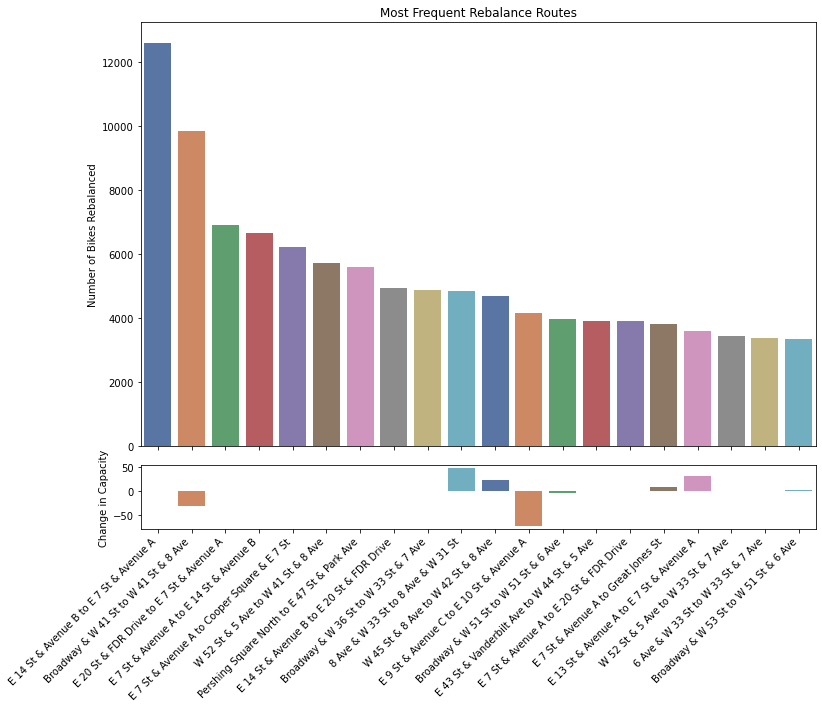

In [ ]:
# combine above with capacity data
f, axs = plt.subplots(
    2, 1, figsize=(12, 8), sharex=True, gridspec_kw={"height_ratios": [1, 0.15]}
)
y = sns.barplot(
    y=rebpair.rebal_count, x=rebpair.rebal_route[:20], ax=axs[0], palette="deep"
)
y.set(
    title="Most Frequent Rebalance Routes",
    xlabel="",
    ylabel="Number of Bikes Rebalanced",
)
x = sns.barplot(
    y=rebpair.rebal_cap_change, x=rebpair.rebal_route[:20], ax=axs[1], palette="deep"
)
f.tight_layout()
x.set_xticklabels(x.get_xticklabels(), rotation=45, horizontalalignment="right")
x.set(
    xlabel="",
    ylabel="Change in Capacity",
)

## Boro
No faceting performed, is possible if desired

### Cumulative Activity

[Text(0, 0, 'Brooklyn'),
 Text(1, 0, 'Manhattan'),
 Text(2, 0, 'Queens'),
 Text(3, 0, 'Queens County'),
 Text(4, 0, 'The Bronx'),
 Text(5, 0, 'Ville-Marie')]

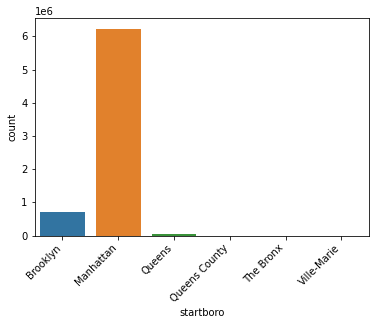

In [ ]:
# total rebalances to a boro
y = sns.countplot(data=rebal, x="startboro")
y.set_xticklabels(y.get_xticklabels(), rotation=45, horizontalalignment="right")

### Movements Within and Across Boros

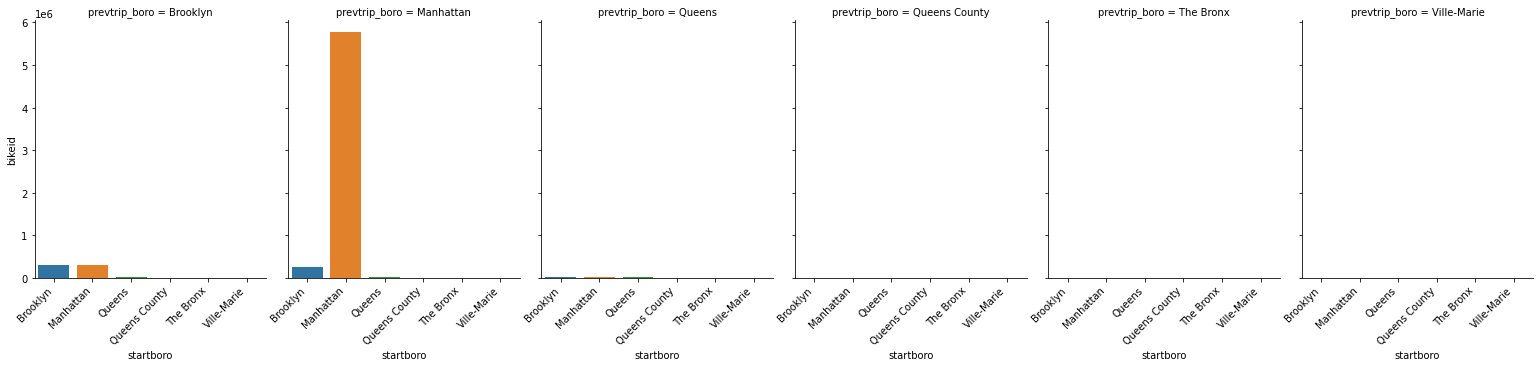

In [ ]:
g = rebal.groupby(["prevtrip_boro", "startboro"])[["bikeid"]].count().reset_index()
x = sns.catplot(
    x="startboro",
    y="bikeid",
    col="prevtrip_boro",
    data=g,
    kind="bar",
    height=4.5,
    aspect=0.8,
)
x.set_xticklabels(rotation=45, horizontalalignment="right")

/home/jgoud/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


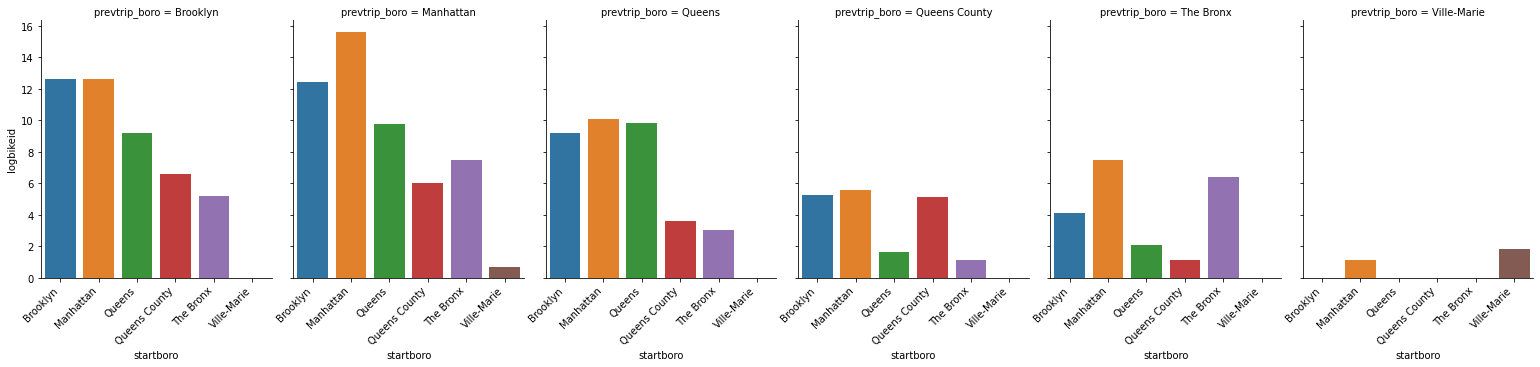

In [ ]:
g = rebal.groupby(["prevtrip_boro", "startboro"])[["bikeid"]].count().reset_index()
g["logbikeid"] = np.log(g.bikeid)
x = sns.catplot(
    x="startboro",
    y="logbikeid",
    col="prevtrip_boro",
    data=g,
    kind="bar",
    height=4.5,
    aspect=0.8,
)
x.set_xticklabels(rotation=45, horizontalalignment="right")

## Estimating Rebalance Time
- Not very accurate, this is just the window in which rebalances happen
- There are negative rebalances - this may highlight an issue with our rebalance approach!?! Do we need an additional sort when creating tables?

In [ ]:
rebal.loc[rebal.rebal_time_hr < 0]

,bikeid,prevtrip_stoptime,prevtrip_endstationid,starttime,startstationid,startstationname,startcapacity,startneighborhood,startboro,startelevation_ft,prevtrip_endstationname,prevtrip_capacity,prevtrip_neighborhood,prevtrip_boro,prevtrip_elevation_ft,rebal_dow,rebal_dom,rebal_week,rebal_month,rebal_year,rebal_elev_change,startelevation_bin,prevtrip_elevation_bin,rebal_time,rebal_time_hr
9,14529,2014-10-18 17:05:03.000,216,2014-10-02 14:21:50.000,536,1 Ave & E 30 St,29.0,Kips Bay,Manhattan,21.078125,Columbia Heights & Cranberry St,37.0,Brooklyn Heights,NaN,35.343750,3,2,40,10,2014,-14.265625,"(0, 25]","(25, 50]",-386.720278,-386.720278
16,14529,2014-10-29 19:06:17.000,157,2014-10-03 06:24:46.000,521,8 Ave & W 31 St,18.0,Chelsea District,Manhattan,33.937500,Henry St & Atlantic Ave,23.0,Brooklyn Heights,NaN,50.250000,4,3,40,10,2014,-16.312500,"(25, 50]","(50, 75]",-636.691944,-636.691944
20,14529,2014-10-31 15:39:23.000,490,2014-10-08 18:05:01.000,3002,South End Ave & Liberty St,NaN,Battery Park City,Manhattan,13.773438,8 Ave & W 33 St,66.0,Garment District,Manhattan,35.937500,2,8,41,10,2014,-22.156250,"(0, 25]","(25, 50]",-549.572778,-549.572778
37,14529,2014-11-29 22:16:27.000,439,2014-11-03 07:55:11.000,521,8 Ave & W 31 St,18.0,Chelsea District,Manhattan,33.937500,E 4 St & 2 Ave,43.0,East Village,Manhattan,37.593750,0,3,45,11,2014,-3.656250,"(25, 50]","(25, 50]",-638.354444,-638.354444
50,14529,2014-12-18 12:10:09.000,250,2014-12-02 08:39:07.000,232,Cadman Plaza E & Tillary St,52.0,Downtown Brooklyn,NaN,79.000000,Lafayette St & Jersey St,40.0,Manhattan Community Board 2,Manhattan,40.843750,1,2,49,12,2014,38.156250,"(75, 100]","(25, 50]",-387.517222,-387.517222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5910696,32097,2017-11-05 01:23:11.000,408,2017-11-05 01:14:19.000,3260,Mercer St & Bleecker St,45.0,West Village,Manhattan,35.937500,Market St & Cherry St,45.0,Two Bridges,Manhattan,13.226562,6,5,44,11,2017,22.718750,"(25, 50]","(0, 25]",-0.147778,-0.147778
5923023,32459,2017-11-05 01:31:31.000,505,2017-11-05 01:29:22.000,3428,8 Ave & W 16 St,36.0,Chelsea District,Manhattan,22.406250,6 Ave & W 33 St,52.0,Manhattan Community Board 5,Manhattan,43.187500,6,5,44,11,2017,-20.781250,"(0, 25]","(25, 50]",-0.035833,-0.035833
5933142,32875,2017-11-05 02:19:14.000,3016,2017-11-05 01:58:42.000,472,E 32 St & Park Ave,55.0,Midtown South,Manhattan,45.093750,Mobile 01,NaN,Manhattan Community Board 8,Manhattan,68.562500,6,5,44,11,2017,-23.468750,"(25, 50]","(50, 75]",-0.342222,-0.342222
5936620,33082,2017-11-05 02:00:30.000,415,2017-11-05 01:57:39.000,347,W Houston St & Hudson St,NaN,Hudson Square,Manhattan,14.671875,Pearl St & Hanover Square,46.0,Financial District,Manhattan,11.656250,6,5,44,11,2017,3.015625,"(0, 25]","(0, 25]",-0.047500,-0.047500


In [ ]:
rebal.shape

(7373117, 25)

In [ ]:
rebal.bikeid.nunique()

32146

In [ ]:
rebal.loc[rebal.rebal_time_hr < 0].bikeid.nunique()

11200

In [ ]:
rebal.loc[rebal.rebal_time_hr < 0].rebal_year.value_counts()

2015    329362
2016    147732
2014     57332
2017         6
2018         1
Name: rebal_year, dtype: int64

In [ ]:
rebal.rebal_time_hr.value_counts().sort_index()

-8756.069444    1
-8756.014167    1
-8755.696944    1
-8753.725556    1
-8752.155556    1
               ..
 8385.202021    1
 8466.663847    1
 8521.995042    1
 8527.482177    1
 8695.771667    1
Name: rebal_time_hr, Length: 2361170, dtype: int64

(0.0, 24.0)

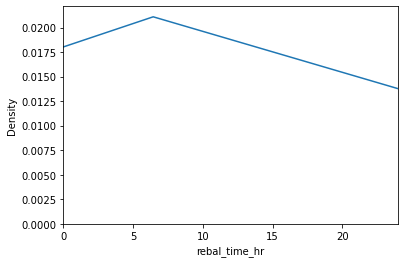

In [ ]:
sns.kdeplot(x=rebal.loc[rebal.rebal_time_hr > 0].rebal_time_hr)
plt.xlim(0, 24)

In [ ]:
rebal2015 = pd.read_parquet("../data/rebalance_parquet/2015_rebalances.parquet")

In [ ]:
rebal2015.head()

,bikeid,prevtrip_stoptime,prevtrip_endstationid,starttime,startstationid
2,14529,1/1/2015 13:24,515,1/12/2015 10:22,479
14,14529,1/12/2015 21:19,352,1/12/2015 6:55,465
16,14529,1/12/2015 8:29,479,1/13/2015 0:14,352
17,14529,1/13/2015 0:26,515,1/13/2015 18:58,402
18,14529,1/13/2015 19:04,280,1/13/2015 9:01,237


In [ ]:
rebal2015.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1740879 entries, 2 to 8626567
Data columns (total 5 columns):
 #   Column                 Dtype 
---  ------                 ----- 
 0   bikeid                 int64 
 1   prevtrip_stoptime      object
 2   prevtrip_endstationid  int64 
 3   starttime              object
 4   startstationid         int64 
dtypes: int64(3), object(2)
memory usage: 79.7+ MB


In [ ]:
rebal2015.sort_values(by=["bikeid", "prevtrip_stoptime"])

,bikeid,prevtrip_stoptime,prevtrip_endstationid,starttime,startstationid
2,14529,1/1/2015 13:24,515,1/12/2015 10:22,479
14,14529,1/12/2015 21:19,352,1/12/2015 6:55,465
16,14529,1/12/2015 8:29,479,1/13/2015 0:14,352
17,14529,1/13/2015 0:26,515,1/13/2015 18:58,402
18,14529,1/13/2015 19:04,280,1/13/2015 9:01,237
...,...,...,...,...,...
8626484,24768,12/25/2015 09:02:58,463,12/25/2015 19:30:46,465
8626485,24768,12/25/2015 20:00:00,465,12/26/2015 12:04:11,442
8626495,24768,12/26/2015 21:50:07,486,12/27/2015 07:55:18,458
8626503,24768,12/28/2015 16:20:49,276,12/28/2015 16:52:12,3002


In [ ]:
rebal2015_asdate = rebal2015.astype({"prevtrip_stoptime": "datetime64"})

In [ ]:
rebal2015_asdate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1740879 entries, 2 to 8626567
Data columns (total 5 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   bikeid                 int64         
 1   prevtrip_stoptime      datetime64[ns]
 2   prevtrip_endstationid  int64         
 3   starttime              object        
 4   startstationid         int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 79.7+ MB


In [ ]:
rebal2015_asdate.sort_values(by=["bikeid", "prevtrip_stoptime"])

,bikeid,prevtrip_stoptime,prevtrip_endstationid,starttime,startstationid
2,14529,2015-01-01 13:24:00,515,1/12/2015 10:22,479
56,14529,2015-01-02 06:55:00,195,1/20/2015 17:32,455
55,14529,2015-01-02 12:40:00,492,1/2/2015 6:37,496
78,14529,2015-01-06 17:47:00,529,1/7/2015 6:53,379
79,14529,2015-01-07 07:05:00,497,1/8/2015 10:54,468
...,...,...,...,...,...
8626484,24768,2015-12-25 09:02:58,463,12/25/2015 19:30:46,465
8626485,24768,2015-12-25 20:00:00,465,12/26/2015 12:04:11,442
8626495,24768,2015-12-26 21:50:07,486,12/27/2015 07:55:18,458
8626503,24768,2015-12-28 16:20:49,276,12/28/2015 16:52:12,3002
